# Cats vs. Dogs Class dataset for multiple annotators


## Imports

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D
from keras.utils.vis_utils import plot_model
from tensorflow.keras import regularizers

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import cv2
import os
import time
import sys

In [2]:

import tensorflow as tf
import numpy as np
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
from scipy.io import savemat
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import mode 
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA

def ook(t):
  lb = LabelBinarizer()
  y_ook = lb.fit_transform(t)  

  if len(np.unique(t))==2:
    y_ook = np.concatenate((1-y_ook.astype(bool), y_ook), axis = 1) 

  return y_ook


def scheduler1(step = 10, ratio = 1.2):
  def scheduler(epoch, lr):
    if epoch % step == 0 and epoch>1:
      return lr/ratio
    else:
      return lr
  return scheduler

In [3]:
# os.chdir('/content/drive/Shareddrives/Multiple Anotators/CrowdLayer/Notebooks')
# cwd = os.getcwd()
# sys.path.append("../Models")


# from Multiple_Annotators_C import MultipleAnnotators_Classification

#import sys
#sys.path.insert(1, '../input/multiple-annotators-c/')
#os.chdir('/Multiple Anotators-c/')
#cwd = os.getcwd()
#sys.path.append('/input/multiple-annotators-c')
#from Multiple_Annotators_C import MultipleAnnotators_Classification

# seed_value= 12321 
# from numpy.random import seed
# seed(seed_value)
# tf.random.set_seed(seed_value)

## Download and Prepare the Dataset

We will use the [Cats vs Dogs](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs) dataset and we can load it via Tensorflow Datasets. The images are labeled 0 for cats and 1 for dogs.

# Multiple annotators model

In [4]:

validation_data = tf.data.experimental.load('/kaggle/input/cat-vs-dog-ma-sin/cats_dogs_Te')
train_data_MA = tf.data.experimental.load('/kaggle/input/cat-vs-dog-ma-sin/cats_dogs_MA_sin_Tr_1')



2023-02-14 20:07:27.356302: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-14 20:07:27.520552: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-14 20:07:27.521463: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-14 20:07:27.523579: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [5]:
image_count = tf.data.experimental.cardinality(train_data_MA).numpy() # los datos de training son 18610 usar subconjunto de 5000
image_count

18610

In [6]:
image_count1 = tf.data.experimental.cardinality(validation_data).numpy() # los datos de training son 18610
image_count1

4652

In [7]:
#X_test = [validation_data[i][0] for i in range(image_count1)]
#Y_true_test = [validation_data[i][1] for i in range(image_count1)]
Y_true_test = np.asarray([aux[1].numpy() for aux  in validation_data])
X_test = np.asarray([aux[0].numpy() for aux  in validation_data])

2023-02-14 20:07:30.108164: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [8]:
image_count

18610

In [9]:
val_size = int(image_count * 0.2)
train_ds_MA = train_data_MA.skip(val_size)
val_ds_MA = train_data_MA.take(val_size)

In [10]:
batch_size = 128
train_batches_MA = train_ds_MA.shuffle(1024).batch(batch_size)
val_batches_MA = val_ds_MA.shuffle(1024).batch(batch_size)
test_batches_MA = validation_data.shuffle(1024).batch(batch_size)

In [11]:
image_count = tf.data.experimental.cardinality(train_ds_MA).numpy() # los datos de training son 18610 usar subconjunto de 5000
image_count

14888

In [12]:
image_count_val = tf.data.experimental.cardinality(val_ds_MA).numpy() # los datos de training son 18610 usar subconjunto de 5000
image_count_val

3722

2023-02-14 20:08:02.319597: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 1 of 1024
2023-02-14 20:08:05.816969: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.


annotator 1
              precision    recall  f1-score   support

         0.0       0.83      0.84      0.84        70
         1.0       0.81      0.79      0.80        58

    accuracy                           0.82       128
   macro avg       0.82      0.82      0.82       128
weighted avg       0.82      0.82      0.82       128

annotator 2
              precision    recall  f1-score   support

         0.0       0.59      0.56      0.57        70
         1.0       0.50      0.53      0.52        58

    accuracy                           0.55       128
   macro avg       0.55      0.55      0.55       128
weighted avg       0.55      0.55      0.55       128

annotator 3
              precision    recall  f1-score   support

         0.0       0.70      0.67      0.69        70
         1.0       0.62      0.66      0.64        58

    accuracy                           0.66       128
   macro avg       0.66      0.66      0.66       128
weighted avg       0.67      0.66     

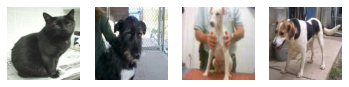

In [13]:
from sklearn.metrics import classification_report
i = 0
fig, ax = plt.subplots(1, 4)
for image, label, label2 in train_batches_MA.take(4):
   # predictedLabel = int(predictions[i] >= 0.5)
   # print(label2)
    ax[i].axis('off')
   # ax[i].set_title(classNames[label[i]])
    ax[i].imshow(image[0])
    i += 1
    for j in range(label2.shape[1]):
      print('annotator',j+1)
      print(classification_report(label ,label2[:,j]))
plt.show()

## Build the classifier from multiple annotators

In [14]:
import tensorflow_datasets as tfds
import tensorflow as tf
import time
from tensorflow.keras import regularizers

import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D
from keras.utils.vis_utils import plot_model

class MultipleAnnotators_Classification():
    def __init__(self, output_dim, num_annotators, q= 0.0001):
        self.K = output_dim
        self.R = num_annotators
        self.q = q
        #self.callbacks #=callbacks
        #self.l1_param=l1_param 
        #self.l2_param=l1_param

    def CrowdLayer(self, input):
       #x = keras.layers.Dense(self.R + self.K, kernel_regularizer=regularizers.L1L2(l1= 1e-2, l2=1e-3),  activation='tanh')(input)
        output_cla = keras.layers.Dense(self.K,  activation='softmax')(input)
        output_ann = keras.layers.Dense(self.R,  activation='sigmoid')(input)
        output = keras.layers.Concatenate()([output_cla, output_ann])
        
        return output
#RCDNN   
    def loss(self):
        def custom_loss(y_true, y_pred):
            # print(y_true,y_pred)
            pred = y_pred[:, :self.K]
            pred = tf.clip_by_value(pred, clip_value_min=1e-9, clip_value_max=1-1e-9) #estabilidad numerica de la funcion de costo
            ann_ = y_pred[:, self.K:]
            Y_true = tf.one_hot(tf.cast(y_true, dtype=tf.int32), depth=self.K, axis=1)
            Y_hat = tf.repeat(tf.expand_dims(pred,-1), self.R, axis = -1)
            p_logreg = tf.math.reduce_prod(tf.math.pow(Y_hat, Y_true), axis=1)
            temp1 = ann_*tf.math.log(p_logreg)  
            temp2 = (1 - ann_)*tf.math.log(1/self.K)*tf.reduce_sum(Y_true,axis=1)
            # temp2 = (tf.ones(tf.shape(ann_)) - ann_)*tf.math.log(1/K)
            # print(tf.reduce_mean(Y_true,axis=1).numpy())
            return -tf.math.reduce_sum((temp1 + temp2))
        return custom_loss
    
#     def loss(self):
#         def custom_loss(y_true, y_pred):
#                # print(y_true,y_pred)
#            # q = 0.1
#             pred = y_pred[:, :self.K]
#             pred = tf.clip_by_value(pred, clip_value_min=1e-9, clip_value_max=1)
#             ann_ = y_pred[:, self.K:]
#             # ann_ = tf.clip_by_value(ann_, clip_value_min=1e-9, clip_value_max=1-1e-9)
#             Y_true = tf.one_hot(tf.cast(y_true, dtype=tf.int32), depth=self.K, axis=1)
#             Y_hat = tf.repeat(tf.expand_dims(pred,-1), self.R, axis = -1)

#             p_gcce = Y_true*(1 - Y_hat**self.q)/self.q
#             temp1 = ann_*tf.math.reduce_sum(p_gcce, axis=1)
#             temp2 = (1 - ann_)*(1-(1/self.K)**self.q)/self.q*tf.reduce_sum(Y_true,axis=1)
#             return tf.math.reduce_sum((temp1 + temp2))
#         return custom_loss

    @tf.function
    def train_step(self, x, Y, y):
        with tf.GradientTape() as tape:
            logits = self.model(x, training=True)
            loss_value = self.loss_fn(Y, logits)
        grads = tape.gradient(loss_value, self.model.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))
        self.train_acc_metric.update_state(y, logits[:, :self.K])
        return loss_value

    @tf.function
    def test_step(self, x, y):
        val_logits = self.model(x, training=False)
        self.val_acc_metric.update_state(y, val_logits[:,:self.K])

    def fit(self, model, Data_tr, Data_Val, epochs):
        self.model = model
        #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
        # Instantiate an optimizer.
        #self.optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4)
        self.optimizer =  tf.keras.optimizers.Adam(learning_rate=1e-3)
        #self.optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, clipnorm=1.0)
        #++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
        # Instantiate a loss function.
        self.loss_fn = self.loss()
        self.train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
        self.val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

        train_loss = np.zeros(epochs)
        train_accur = np.zeros(epochs)
        val_accur = np.zeros(epochs)
        val_loss = np.zeros(epochs)

        for epoch in range(epochs):
            print("\nStart of epoch %d" % (epoch,))
            start_time = time.time()

            # Iterate over the batches of the dataset.
            for step, (x_batch_train, y_batch_train, Y_batch_train) in enumerate(Data_tr):
                # print(y_batch_train, Y_batch_train)
                loss_value = self.train_step(x_batch_train, Y_batch_train, y_batch_train)

                # Log every 200 batches.
                if step % 10 == 0:
                    train_acc = self.train_acc_metric.result()
                    print(
                      "Training loss (for one batch) at step %d: %.4f, Accuracy: %.4f"
                      % (step, float(loss_value), float(train_acc))
                            )
                # print("Seen so far: %d samples" % ((step + 1) * batch_size))



            # Run a validation loop at the end of each epoch.
            for x_batch_val, y_batch_val,Y_batch_val in Data_Val:

                val_logits = model(x_batch_val, training=False)

                val_loss_value = self.loss_fn(Y_batch_val, val_logits)

                self.val_acc_metric.update_state(y_batch_val, val_logits[:,:self.K])
                
               # np.round(np.mean([model(x_batch_val, training= True) for sample in range(100)]), 2)


             # Display metrics at the end of each epoch.
            train_acc = self.train_acc_metric.result()
            val_acc = self.val_acc_metric.result()


            print('---- Training ----')
            print("Training loss: %.4f" % (float(loss_value),))
            print("Training acc over epoch: %.4f" % (float(train_acc),))
            # Reset training metrics at the end of each epoch
            self.train_acc_metric.reset_states()
            self.val_acc_metric.reset_states()


            train_loss[epoch] = float(loss_value)
            train_accur[epoch] = float(train_acc)

            val_accur[epoch] = float(val_acc)
            val_loss[epoch] = float(val_loss_value) 


            print('---- Validation ----')
            print("Validation loss: %.4f" % (float(val_loss_value),))
            print("Validation acc: %.4f" % (float(val_acc),))

            print("Time taken: %.2fs" % (time.time() - start_time))

        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle('Loss and accuracy')
        ax1.plot(range(1,epochs+1),train_loss)
        ax1.plot(range(1,epochs+1), val_loss)
        ax2.plot(range(1,epochs+1),train_accur)
        ax2.plot(range(1,epochs+1),val_accur)
        #plt.figure(figsize=(16,9))
        ax1.set(xlabel= 'Epoch', ylabel="Loss")
        ax2.set(xlabel= 'Epoch',ylabel="Accuracy")
        ax1.legend(['Training_loss', 'Validation_loss'])
        ax2.legend(['Training', 'Validation'])
        ax1.grid()
        ax2.grid()
        plt.show()
        return self.model

    def eval_model(self, Data):
        self.val_acc_metric = keras.metrics.SparseCategoricalAccuracy()
        for x_batch_val, y_batch_val in Data:
            self.test_step(x_batch_val, y_batch_val)

        val_acc = self.val_acc_metric.result()
        self.val_acc_metric.reset_states()
        return val_acc






In [15]:
def custom_loss(y_true, y_pred):
  # print(y_true,y_pred)
  K = 2 #len(np.unique(y_true))
  R = 5
  q = 0.1
  pred = y_pred[:, K]
  pred = tf.clip_by_value(pred, clip_value_min=1e-9, clip_value_max=1)
  ann_ = y_pred[:,  K:]
  # ann_ = tf.clip_by_value(ann_, clip_value_min=1e-9, clip_value_max=1-1e-9)
  Y_true = tf.one_hot(tf.cast(y_true, dtype=tf.int32), depth=K, axis=1)
  Y_hat = tf.repeat(tf.expand_dims(pred,-1), R, axis = -1)

  p_gcce = Y_true*(1 - Y_hat**q)/q
  temp1 = ann_*tf.math.reduce_sum(p_gcce, axis=1)
  temp2 = (1 - ann_)*(1-(1/K)**q)/q*tf.reduce_sum(Y_true,axis=1)
  return tf.math.reduce_sum((temp1 + temp2))



In [16]:

import tensorflow as tf
import numpy as np
from scipy.io import loadmat
from sklearn.preprocessing import StandardScaler
from scipy.io import savemat
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import mode 
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA

def ook(t):
  lb = LabelBinarizer()
  y_ook = lb.fit_transform(t)  

  if len(np.unique(t))==2:
    y_ook = np.concatenate((1-y_ook.astype(bool), y_ook), axis = 1) 

  return y_ook


def scheduler1(step = 10, ratio = 1.2):
  def scheduler(epoch, lr):
    if epoch % step == 0 and epoch>1:
      return lr/ratio
    else:
      return lr
  return scheduler

In [17]:
MA = MultipleAnnotators_Classification(2, 5, 0.001)
 
def create_model():
   
    l1 = 1e-2
    initializer = tf.keras.initializers.GlorotNormal(seed=100)
    # Block 1
    inputs = keras.layers.Input(shape=(150, 150, 3), name='entrada')
    x = keras.layers.BatchNormalization()(inputs)
    x = keras.layers.Conv2D(32, (3, 3), activation="relu" , name="block1_conv1", bias_initializer='zeros', kernel_initializer=initializer)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name="block1_pool")(x)


    # Block 2
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(32, (3, 3), activation="relu", bias_initializer='zeros', kernel_initializer=initializer, name="block2_conv1")(x)
    x = keras.layers.BatchNormalization()(x)
    #x = keras.layers.Dropout(0.2)(x)
    
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name="block2_pool")(x)

    # Block 3
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation="relu",bias_initializer='zeros', kernel_initializer=initializer, name="block3_conv1" )(x)             
    x = keras.layers.BatchNormalization()(x)
   # x = keras.layers.Dropout(0.2)(x)
   
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name="block3_pool")(x)
    
    # Block 4
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64, (3, 3), activation="relu",bias_initializer='zeros', kernel_initializer=initializer, name="block4_conv1")(x)            
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name="block4_pool")(x)
    #x = keras.layers.Dropout(0.2)(x)
    
    #x = keras.layers.GlobalAveragePooling2D()(x)
   
    x = keras.layers.Flatten()(x)
    #x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dense(128, activation="relu",bias_initializer='zeros', kernel_initializer=initializer)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.5)(x)
    output = MA.CrowdLayer(x)
    model = keras.Model(inputs=inputs,outputs=output)

    return model


  
  

In [18]:
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# callbacks = [
#     EarlyStopping(patience=10, verbose=1),
#     ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.00001, verbose=1),
#     ModelCheckpoint('model1.h5', verbose=1, save_best_only=True, save_weights_only=True)
# ] ,  callbacks = [callback1, callback2]

In [19]:
# classification_report_r= []
# model = create_model()
# K=2
# R=5
# NUM_RUNS = 5
# N_EPOCHS = 30
# val_acc = np.zeros(NUM_RUNS)
# for i in range(NUM_RUNS):
#   MA = MultipleAnnotators_Classification(K, R, 0.1)
#   model = create_model()
#   optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0)
#   model.compile(optimizer=optimizer, loss= MA.loss())
#   history_model = model.fit(train_batches_MA, validation_data=val_batches_MA, epochs= N_EPOCHS, callbacks=callbacks, verbose=0)
#   #model = MA.fit(model, Data_train_MA, N_EPOCHS)
#   pred_2 = model.predict(X_test)

#   lambda_R_ = pred_2[:, K:] #annotators reliability prediction N x R   
#   classification_report_r += [classification_report( pred_2[:,:K].argmax(axis=1),Y_true_test.ravel(),output_dict=True)]
#   print(classification_report( pred_2[:,:K].argmax(axis=1),Y_true_test.ravel()))
#   #val_acc[i] = MA.eval_model(test_batches_MA)
#   #print("Validation acc: %.4f" % (float(val_acc[i]),))
#   # Create the history figure
#   plt.figure(figsize=(16,9))
#   for i in  history_model.history:
#       plt.plot(history_model.history[i],label=i)
#   plt.title('Model history')
#   plt.legend()
#   plt.grid()

# import pandas as pd
# df = pd.DataFrame(val_acc)
# #df.to_csimport pandas as pddf = pd.DataFrame(val_acc)#df.to_csv('/kaggle/working/CatDogs_MA_InceptionV3.csv',index=False) # save to notebook output​v('/kaggle/working/CatDogs_MA_InceptionV3.csv',index=False) # save to notebook output


In [20]:
callback1 = tf.keras.callbacks.TerminateOnNaN()
callback2 = tf.keras.callbacks.LearningRateScheduler(scheduler1(ratio = 1))
#callback2 = tf.keras.callbacks.LearningRateScheduler(scheduler2)
callback3 = tf.keras.callbacks.EarlyStopping(monitor="loss", min_delta=1e-2,
                                         patience=15, verbose=0, mode="auto",
                                         baseline=None, restore_best_weights=True)


Start of epoch 0


2023-02-14 20:08:11.870191: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


Training loss (for one batch) at step 0: 602.5605, Accuracy: 0.5312
Training loss (for one batch) at step 10: 573.9174, Accuracy: 0.5256
Training loss (for one batch) at step 20: 530.3674, Accuracy: 0.5167
Training loss (for one batch) at step 30: 526.7459, Accuracy: 0.5202
Training loss (for one batch) at step 40: 500.4533, Accuracy: 0.5103
Training loss (for one batch) at step 50: 476.6234, Accuracy: 0.5150
Training loss (for one batch) at step 60: 482.1093, Accuracy: 0.5177
Training loss (for one batch) at step 70: 482.3872, Accuracy: 0.5143
Training loss (for one batch) at step 80: 468.0260, Accuracy: 0.5119
Training loss (for one batch) at step 90: 461.2769, Accuracy: 0.5129
Training loss (for one batch) at step 100: 461.7726, Accuracy: 0.5113
Training loss (for one batch) at step 110: 464.1553, Accuracy: 0.5125
---- Training ----
Training loss: 144.7259
Training acc over epoch: 0.5134
---- Validation ----
Validation loss: 34.8151
Validation acc: 0.5134
Time taken: 73.69s

Start o

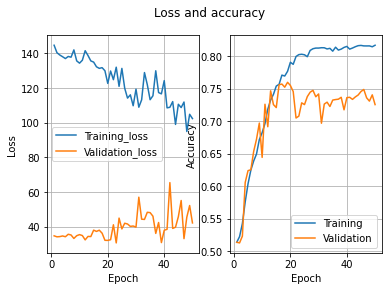

Validation acc: 0.7350
Validation AUC: 0.7349
Validation Balanced_ACC: 0.4704
Validation AUCSK: 0.8097
Validation MI: 0.1180
Validation Normalized MI: 0.1713
Validation Adjusted MI: 0.1713

Start of epoch 0
Training loss (for one batch) at step 0: 653.4407, Accuracy: 0.4609
Training loss (for one batch) at step 10: 556.9301, Accuracy: 0.5043
Training loss (for one batch) at step 20: 551.3837, Accuracy: 0.4914
Training loss (for one batch) at step 30: 503.0959, Accuracy: 0.4927
Training loss (for one batch) at step 40: 532.8497, Accuracy: 0.4970
Training loss (for one batch) at step 50: 500.8148, Accuracy: 0.4972
Training loss (for one batch) at step 60: 475.1050, Accuracy: 0.5024
Training loss (for one batch) at step 70: 484.6721, Accuracy: 0.5054
Training loss (for one batch) at step 80: 471.0672, Accuracy: 0.5080
Training loss (for one batch) at step 90: 469.2424, Accuracy: 0.5111
Training loss (for one batch) at step 100: 459.8274, Accuracy: 0.5104
Training loss (for one batch) at s

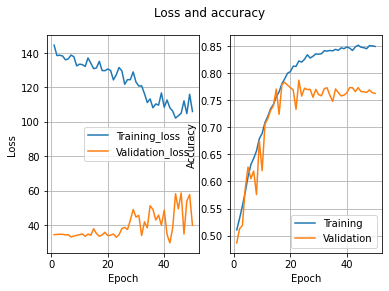

Validation acc: 0.7549
Validation AUC: 0.7563
Validation Balanced_ACC: 0.4912
Validation AUCSK: 0.8248
Validation MI: 0.1303
Validation Normalized MI: 0.1896
Validation Adjusted MI: 0.1896

Start of epoch 0
Training loss (for one batch) at step 0: 633.6382, Accuracy: 0.5078
Training loss (for one batch) at step 10: 645.6832, Accuracy: 0.4893
Training loss (for one batch) at step 20: 577.5479, Accuracy: 0.5063
Training loss (for one batch) at step 30: 549.8953, Accuracy: 0.5043
Training loss (for one batch) at step 40: 505.4513, Accuracy: 0.5044
Training loss (for one batch) at step 50: 505.1583, Accuracy: 0.5040
Training loss (for one batch) at step 60: 515.3348, Accuracy: 0.5031
Training loss (for one batch) at step 70: 469.0932, Accuracy: 0.5052
Training loss (for one batch) at step 80: 482.1228, Accuracy: 0.5071
Training loss (for one batch) at step 90: 481.1465, Accuracy: 0.5086
Training loss (for one batch) at step 100: 470.6030, Accuracy: 0.5098
Training loss (for one batch) at s

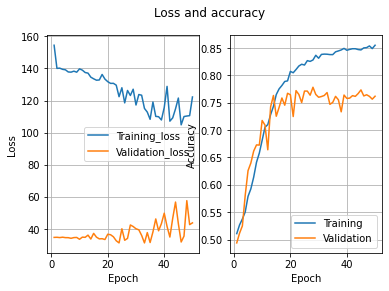

Validation acc: 0.7724
Validation AUC: 0.7735
Validation Balanced_ACC: 0.5099
Validation AUCSK: 0.8362
Validation MI: 0.1413
Validation Normalized MI: 0.2057
Validation Adjusted MI: 0.2057

Start of epoch 0
Training loss (for one batch) at step 0: 627.0288, Accuracy: 0.4922
Training loss (for one batch) at step 10: 611.8431, Accuracy: 0.4709
Training loss (for one batch) at step 20: 535.9321, Accuracy: 0.4918
Training loss (for one batch) at step 30: 553.5740, Accuracy: 0.4957
Training loss (for one batch) at step 40: 488.4061, Accuracy: 0.5008
Training loss (for one batch) at step 50: 507.6210, Accuracy: 0.5074
Training loss (for one batch) at step 60: 481.7278, Accuracy: 0.5028
Training loss (for one batch) at step 70: 484.8870, Accuracy: 0.5040
Training loss (for one batch) at step 80: 460.7573, Accuracy: 0.5062
Training loss (for one batch) at step 90: 468.0842, Accuracy: 0.5050
Training loss (for one batch) at step 100: 470.1277, Accuracy: 0.5052
Training loss (for one batch) at s

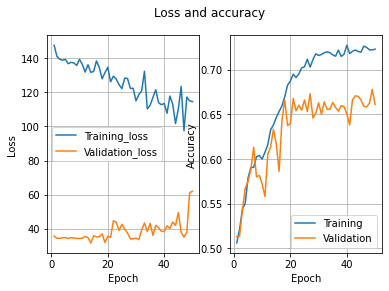

Validation acc: 0.6728
Validation AUC: 0.6751
Validation Balanced_ACC: 0.4696
Validation AUCSK: 0.8056
Validation MI: 0.1233
Validation Normalized MI: 0.1799
Validation Adjusted MI: 0.1799

Start of epoch 0
Training loss (for one batch) at step 0: 664.3907, Accuracy: 0.5312
Training loss (for one batch) at step 10: 621.9774, Accuracy: 0.5249
Training loss (for one batch) at step 20: 602.5035, Accuracy: 0.5283
Training loss (for one batch) at step 30: 542.4471, Accuracy: 0.5189
Training loss (for one batch) at step 40: 532.5485, Accuracy: 0.5112
Training loss (for one batch) at step 50: 511.1518, Accuracy: 0.5124
Training loss (for one batch) at step 60: 498.4182, Accuracy: 0.5119
Training loss (for one batch) at step 70: 482.8534, Accuracy: 0.5062
Training loss (for one batch) at step 80: 459.0420, Accuracy: 0.5080
Training loss (for one batch) at step 90: 474.1564, Accuracy: 0.5065
Training loss (for one batch) at step 100: 476.9121, Accuracy: 0.5060
Training loss (for one batch) at s

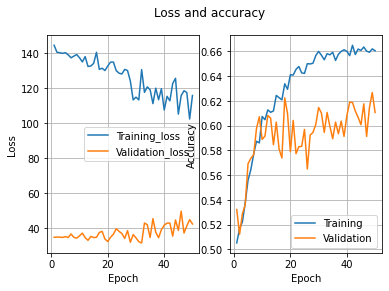

Validation acc: 0.6051
Validation AUC: 0.6045
Validation Balanced_ACC: 0.4171
Validation AUCSK: 0.7745
Validation MI: 0.1038
Validation Normalized MI: 0.1514
Validation Adjusted MI: 0.1514

Start of epoch 0
Training loss (for one batch) at step 0: 672.8365, Accuracy: 0.4766
Training loss (for one batch) at step 10: 601.5826, Accuracy: 0.5099
Training loss (for one batch) at step 20: 563.2991, Accuracy: 0.4847
Training loss (for one batch) at step 30: 540.3102, Accuracy: 0.4887
Training loss (for one batch) at step 40: 548.2624, Accuracy: 0.4990
Training loss (for one batch) at step 50: 506.2449, Accuracy: 0.5015
Training loss (for one batch) at step 60: 518.9839, Accuracy: 0.4976
Training loss (for one batch) at step 70: 529.9923, Accuracy: 0.4976
Training loss (for one batch) at step 80: 498.8608, Accuracy: 0.4981
Training loss (for one batch) at step 90: 506.7168, Accuracy: 0.4991
Training loss (for one batch) at step 100: 496.8004, Accuracy: 0.4978
Training loss (for one batch) at s

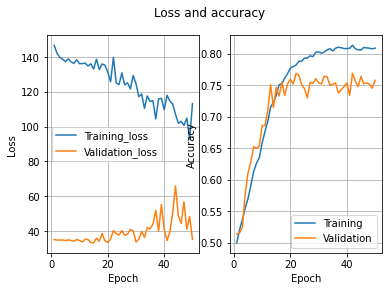

Validation acc: 0.7575
Validation AUC: 0.7584
Validation Balanced_ACC: 0.4337
Validation AUCSK: 0.7850
Validation MI: 0.1109
Validation Normalized MI: 0.1616
Validation Adjusted MI: 0.1616

Start of epoch 0
Training loss (for one batch) at step 0: 594.4665, Accuracy: 0.5000
Training loss (for one batch) at step 10: 592.2834, Accuracy: 0.5234
Training loss (for one batch) at step 20: 543.6012, Accuracy: 0.5219
Training loss (for one batch) at step 30: 513.9310, Accuracy: 0.5161
Training loss (for one batch) at step 40: 504.2957, Accuracy: 0.5179
Training loss (for one batch) at step 50: 511.1634, Accuracy: 0.5153
Training loss (for one batch) at step 60: 479.4170, Accuracy: 0.5170
Training loss (for one batch) at step 70: 471.6881, Accuracy: 0.5150
Training loss (for one batch) at step 80: 472.4713, Accuracy: 0.5135
Training loss (for one batch) at step 90: 462.8412, Accuracy: 0.5154
Training loss (for one batch) at step 100: 467.8433, Accuracy: 0.5132
Training loss (for one batch) at s

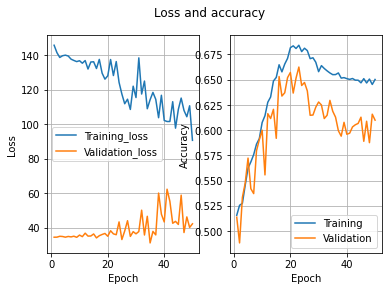

Validation acc: 0.6337
Validation AUC: 0.6333
Validation Balanced_ACC: 0.4099
Validation AUCSK: 0.7703
Validation MI: 0.1007
Validation Normalized MI: 0.1468
Validation Adjusted MI: 0.1468

Start of epoch 0
Training loss (for one batch) at step 0: 688.1454, Accuracy: 0.4375
Training loss (for one batch) at step 10: 673.8788, Accuracy: 0.5121
Training loss (for one batch) at step 20: 542.9769, Accuracy: 0.5041
Training loss (for one batch) at step 30: 560.6143, Accuracy: 0.5111
Training loss (for one batch) at step 40: 540.5743, Accuracy: 0.5099
Training loss (for one batch) at step 50: 504.6660, Accuracy: 0.5046
Training loss (for one batch) at step 60: 485.3459, Accuracy: 0.5055
Training loss (for one batch) at step 70: 475.3705, Accuracy: 0.5111
Training loss (for one batch) at step 80: 466.6476, Accuracy: 0.5097
Training loss (for one batch) at step 90: 480.8861, Accuracy: 0.5110
Training loss (for one batch) at step 100: 461.1818, Accuracy: 0.5104
Training loss (for one batch) at s

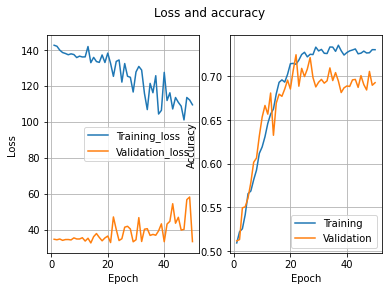

Validation acc: 0.6801
Validation AUC: 0.6820
Validation Balanced_ACC: 0.4041
Validation AUCSK: 0.7685
Validation MI: 0.0974
Validation Normalized MI: 0.1421
Validation Adjusted MI: 0.1421

Start of epoch 0
Training loss (for one batch) at step 0: 646.2151, Accuracy: 0.5312
Training loss (for one batch) at step 10: 598.6373, Accuracy: 0.4865
Training loss (for one batch) at step 20: 566.9996, Accuracy: 0.4985
Training loss (for one batch) at step 30: 546.5002, Accuracy: 0.5020
Training loss (for one batch) at step 40: 521.3660, Accuracy: 0.5067
Training loss (for one batch) at step 50: 515.0674, Accuracy: 0.5058
Training loss (for one batch) at step 60: 491.5873, Accuracy: 0.5102
Training loss (for one batch) at step 70: 466.9210, Accuracy: 0.5112
Training loss (for one batch) at step 80: 483.9078, Accuracy: 0.5131
Training loss (for one batch) at step 90: 468.3730, Accuracy: 0.5142
Training loss (for one batch) at step 100: 462.4034, Accuracy: 0.5127
Training loss (for one batch) at s

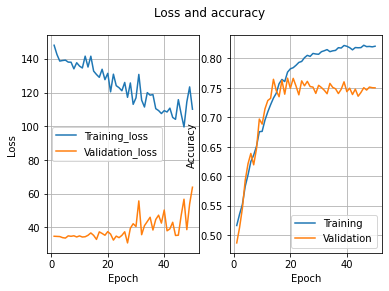

Validation acc: 0.7573
Validation AUC: 0.7580
Validation Balanced_ACC: 0.4166
Validation AUCSK: 0.7761
Validation MI: 0.1028
Validation Normalized MI: 0.1499
Validation Adjusted MI: 0.1499

Start of epoch 0
Training loss (for one batch) at step 0: 630.5133, Accuracy: 0.4922
Training loss (for one batch) at step 10: 594.8061, Accuracy: 0.5114
Training loss (for one batch) at step 20: 560.0387, Accuracy: 0.5056
Training loss (for one batch) at step 30: 560.6892, Accuracy: 0.5048
Training loss (for one batch) at step 40: 515.0499, Accuracy: 0.5042
Training loss (for one batch) at step 50: 505.3909, Accuracy: 0.5080
Training loss (for one batch) at step 60: 504.3572, Accuracy: 0.5100
Training loss (for one batch) at step 70: 480.6252, Accuracy: 0.5125
Training loss (for one batch) at step 80: 472.3816, Accuracy: 0.5123
Training loss (for one batch) at step 90: 475.7220, Accuracy: 0.5114
Training loss (for one batch) at step 100: 469.8789, Accuracy: 0.5082
Training loss (for one batch) at s

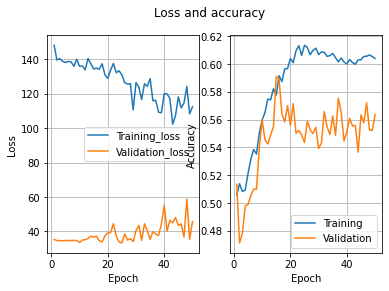

Validation acc: 0.5795
Validation AUC: 0.5784
Validation Balanced_ACC: 0.3907
Validation AUCSK: 0.7586
Validation MI: 0.0942
Validation Normalized MI: 0.1373
Validation Adjusted MI: 0.1373


In [21]:
from sklearn.metrics import classification_report, balanced_accuracy_score, roc_auc_score
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score, adjusted_mutual_info_score
#l1 =0.0001
NUM_RUNS = 10
N_EPOCHS = 50
ACC = np.zeros(NUM_RUNS)
AUC = np.zeros(NUM_RUNS)
AUCSK = np.zeros(NUM_RUNS)
MI = np.zeros(NUM_RUNS)
NMI = np.zeros(NUM_RUNS)
AMI = np.zeros(NUM_RUNS)
BACC = np.zeros(NUM_RUNS)
BACC1 = []
MI1 = []
NMI1 =[]
AMI1 = []
AUCSK1 = []
#model = create_model()
K=2
R=5

val_acc = np.zeros(NUM_RUNS)
AUC= np.zeros(NUM_RUNS)

for i in range(NUM_RUNS):
  MA = MultipleAnnotators_Classification(2, 5, 0.1)
  model =  create_model()
  model = MA.fit(model, train_batches_MA, val_batches_MA, N_EPOCHS)
  #model = MA.fit(model, Data_train_MA, N_EPOCHS)
  ACC[i] = MA.eval_model(test_batches_MA)
  print("Validation acc: %.4f" % (float(ACC[i]),))
    
 #AUC =======================
  val_AUC_metric = tf.keras.metrics.AUC( from_logits = True)
  for x_batch_val, y_batch_val in test_batches_MA:
      val_logits = model(x_batch_val.numpy(), training=False)
      # tf.print(y_batch_val)
      val_AUC_metric.update_state(y_batch_val, val_logits[:,:K].numpy().argmax(axis=1).astype('float'))
      BACC1.append(balanced_accuracy_score(y_batch_val.numpy().squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze(), adjusted=True))
      MI1.append(mutual_info_score(y_batch_val.numpy().squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze()))
      NMI1.append(normalized_mutual_info_score(y_batch_val.numpy().squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze()))
      AMI1.append(normalized_mutual_info_score(y_batch_val.numpy().squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze()))
      AUCSK1.append(roc_auc_score(ook(y_batch_val.numpy()), val_logits[:,:K].numpy().astype('float')))
    

  val_AUC = val_AUC_metric.result()
  val_AUC_metric.reset_states()
  val_AUC = val_AUC.numpy()
  print("Validation AUC: %.4f" % (float(val_AUC),))
  AUC[i] = val_AUC
  #===================================================
    
    

  # balanced. Accurcy
  BACC[i] = np.array(BACC1).mean() # balanced_accuracy_score(Y_true_test.squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze(), adjusted=True)
  print("Validation Balanced_ACC: %.4f" % (float(BACC[i])))
  AUCSK[i] = np.array(AUCSK1).mean() 
  print("Validation AUCSK: %.4f" % (float( AUCSK[i] )))
  #MI
  
  MI[i] =  np.array(MI1).mean()  #mutual_info_score(Y_true_test.squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze())
  print("Validation MI: %.4f" % (float(MI[i]),))
  NMI[i] =  np.array(NMI1).mean()   #normalized_mutual_info_score(Y_true_test.squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze())
  print("Validation Normalized MI: %.4f" % (float(NMI[i]),))
  AMI[i]= np.array(AMI1).mean()  #adjusted_mutual_info_score(Y_true_test.squeeze(), val_logits[:,:K].numpy().argmax(axis=1).squeeze())
  print("Validation Adjusted MI: %.4f" % (float(AMI[i]),))

import pandas as pd
df = pd.DataFrame(val_acc)
#df.to_csv('/content/CatDogs_MA_InceptionV3.csv',index=False) # save to notebook output

In [22]:
ook(y_batch_val.numpy()).shape

(44, 2)

In [23]:
val_logits.numpy().astype('float').shape

(44, 7)

In [24]:
print('Average Accuracy: ', np.round( ACC.mean(),4)*100) 
print('Average std: ',np.round(np.std( ACC),4)*100)
print('==============================================')
print('Average AUC: ', np.round( AUC.mean(),4)*100) 
print('Average AUC std: ',np.round(np.std( AUC),4)*100)
print('Average std: ',np.round(np.std( ACC),4)*100)
print('==============================================')
print('Average AUCSK: ', np.round( AUCSK.mean(),4)*100) 
print('Average AUCSK std: ',np.round(np.std( AUCSK),4)*100)
print('==============================================')
print('Average Balanced Accuracy: ', np.round( BACC.mean(),4)*100) 
print('Average std: ',np.round(np.std( BACC),4)*100)
print('==============================================')
print('Average MI: ', np.round( MI.mean(),4)*100) 
print('Average std: ',np.round(np.std(MI),4)*100)
print('==============================================')
print('Average Normalized MI: ', np.round( NMI.mean(),4)*100) 
print('Average std: ',np.round(np.std(NMI),4)*100)
print('==============================================')
print('Average Ajdusted MI: ', np.round( AMI.mean(),4)*100) 
print('Average std: ',np.round(np.std(AMI),4)*100)

Average Accuracy:  69.48
Average std:  6.7
Average AUC:  69.54
Average AUC std:  6.76
Average std:  6.7
Average AUCSK:  79.09
Average AUCSK std:  2.5
Average Balanced Accuracy:  44.13
Average std:  3.88
Average MI:  11.23
Average std:  1.47
Average Normalized MI:  16.36
Average std:  2.13
Average Ajdusted MI:  16.36
Average std:  2.13
